In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, timedelta
from tqdm import tqdm
%matplotlib inline
sns.set_style('dark')

In [2]:
train_pre = pd.read_csv('Data/初赛/train.csv')
test_pre = pd.read_csv('Data/初赛/test.csv')
answer_pre = pd.read_csv('Data/初赛/answer.csv')
answer_pre.columns = ['timestamp', 'temp_in']
train_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
test_pre = pd.merge(test_pre, answer_pre, on='timestamp', how='left')
test_pre.temp_in.fillna(31.5, inplace=True)
train_pre['time'] = pd.to_datetime(train_pre[['year', 'month', 'day', 'hour', 'minute']])
test_pre['time'] = pd.to_datetime(test_pre[['year', 'month', 'day', 'hour', 'minute']])
data_pre = pd.concat([train_pre, test_pre])

train_final = pd.read_csv('Data/复赛/train.csv')
test_final = pd.read_csv('Data/复赛/test.csv')
train_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
train_final['time'] = pd.to_datetime(train_final[['year', 'month', 'day', 'hour', 'minute']])
test_final['time'] = pd.to_datetime(test_final[['year', 'month', 'day', 'hour', 'minute']])

Preliminary:

- train: 2019-3-14 01:00 ~ 2019-4-3 00:59 per min
- test: 2019-4-3 01:00 ~ 2019-4-13 00:57 per 30mins

Final:
- train: 2020-01-13 00:00 ~ 2020-01-22 23:59 per min
- test: 2020-02-01 00:10 ~ 2020-02-05 22:10 per 2hours

In [3]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(14, 32):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(3)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

for day in range(1, 3):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(4)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])
train_pre_full = full_time.loc[(full_time.time >= '2019-3-14 01') & (full_time.time < '2019-4-3 01'), :]

train_pre = pd.merge(train_pre_full, train_pre, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_pre.drop(['timestamp', 'second'], axis=1, inplace=True)
train_pre.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_pre.reset_index(inplace=True, drop=True)

In [4]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(13, 23):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2020)
            time['month'].append(1)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])

train_final = pd.merge(full_time, train_final, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_final.drop(['timestamp', 'second'], axis=1, inplace=True)
train_final.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_final.reset_index(inplace=True, drop=True)

In [5]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)

In [6]:
for feat in ['hum_out', 'hum_in', 'air_out', 'air_in']:
    for df in [train_pre, train_final]:
        lower, upper = np.percentile(df[feat], (5, 95))
        df.loc[(df[feat] < lower) | (df[feat] > upper), feat] = np.NaN

In [7]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)

<AxesSubplot:>

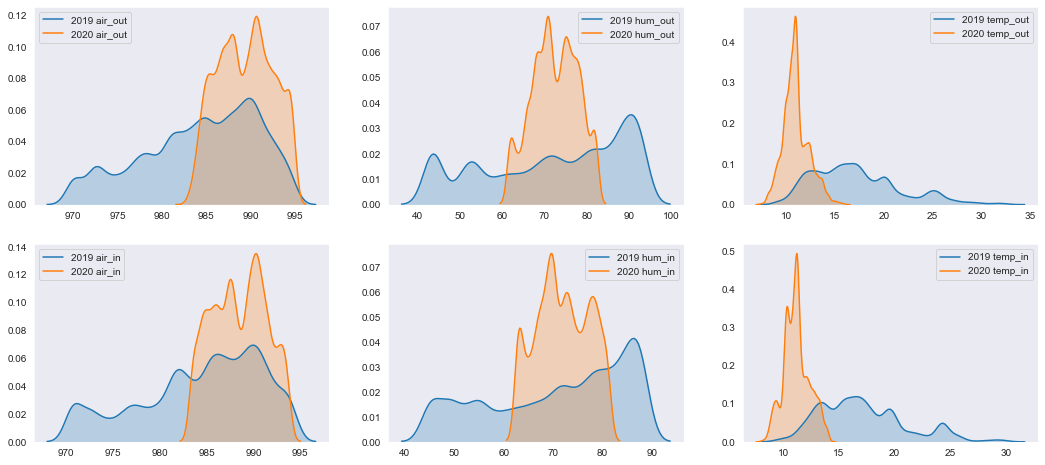

In [8]:
plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
sns.kdeplot(train_pre.air_out, shade=True, label='2019 air_out')
sns.kdeplot(train_final.air_out, shade=True, label='2020 air_out')
plt.subplot(2,3,4)
sns.kdeplot(train_pre.air_in, shade=True, label='2019 air_in')
sns.kdeplot(train_final.air_in, shade=True, label='2020 air_in')
plt.subplot(2,3,2)
sns.kdeplot(train_pre.hum_out, shade=True, label='2019 hum_out')
sns.kdeplot(train_final.hum_out, shade=True, label='2020 hum_out')
plt.subplot(2,3,5)
sns.kdeplot(train_pre.hum_in, shade=True, label='2019 hum_in')
sns.kdeplot(train_final.hum_in, shade=True, label='2020 hum_in')
plt.subplot(2,3,3)
sns.kdeplot(train_pre.temp_out, shade=True, label='2019 temp_out')
sns.kdeplot(train_final.temp_out, shade=True, label='2020 temp_out')
plt.subplot(2,3,6)
sns.kdeplot(train_pre.temp_in, shade=True, label='2019 temp_in')
sns.kdeplot(train_final.temp_in, shade=True, label='2020 temp_in')